In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import LSTM, Dropout, Dense, Attention, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the new dataset
path = "/content/AEP_hourly.csv"  # Update the path to your actual file location
data = pd.read_csv(path, parse_dates=['Datetime'])

# Resample to hourly if needed (this dataset is already hourly)
data.set_index('Datetime', inplace=True)
data = data.resample('H').mean().reset_index()

# Drop any rows with missing values
data.dropna(inplace=True)

In [ ]:
# Normalize the AEP_MW values
scaler = MinMaxScaler()
data['AEP_MW'] = scaler.fit_transform(data[['AEP_MW']])

# Apply PCA
n_components = 1  # Since we have only one feature after normalization, n_components can be 1
pca = PCA(n_components=n_components)
df_consumption_pca = pca.fit_transform(data[['AEP_MW']])

# Convert PCA result back to DataFrame
df_consumption_pca = pd.DataFrame(df_consumption_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Reshape the data for LSTM
n_timesteps = 24  # For hourly data, using 24 hours (1 day) as the time window
n_samples = df_consumption_pca.shape[0] // n_timesteps
reshaped_data_pca = df_consumption_pca.values[:n_samples * n_timesteps].reshape(n_samples, n_timesteps, n_components)

In [ ]:
# Split the data into training and testing sets
X = reshaped_data_pca[:, :-1, :]
Y = reshaped_data_pca[:, -1, :]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"The training set has {X_train.shape}")
print(f"The test set has {X_test.shape}")

The training set has (4041, 23, 1)
The test set has (1011, 23, 1)


In [ ]:
# Define RMSE and MAE metrics
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

In [ ]:
# Define model with regularization
def build_model_with_regularization(units=50, dropout_rate=0.2, learning_rate=0.001, l2_lambda=0.001):
    model = tf.keras.Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(units, kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units, activation='leaky_relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dense(tfp.layers.IndependentNormal.params_size(1), kernel_regularizer=l2(l2_lambda)),
        tfp.layers.IndependentNormal(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=lambda y, rv_y: -rv_y.log_prob(y), metrics=[rmse, mae])
    return model

# Define model with attention
def build_model_with_attention(units=50, dropout_rate=0.2, learning_rate=0.001, l2_lambda=0.001):
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(inputs)
    attention_out = Attention()([lstm_out, lstm_out])
    lstm_out = Dropout(dropout_rate)(attention_out)
    lstm_out = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(lstm_out)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = Bidirectional(LSTM(units, kernel_regularizer=l2(l2_lambda)))(lstm_out)
    dropout_out = Dropout(dropout_rate)(lstm_out)
    dense_out = Dense(units, activation='leaky_relu', kernel_regularizer=l2(l2_lambda))(dropout_out)
    params_out = Dense(tfp.layers.IndependentNormal.params_size(1), kernel_regularizer=l2(l2_lambda))(dense_out)
    outputs = tfp.layers.IndependentNormal(1)(params_out)

    model = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=lambda y, rv_y: -rv_y.log_prob(y), metrics=[rmse, mae])
    return model

# Function to train and evaluate model
def train_and_evaluate_model(units, dropout_rate, learning_rate, l2_lambda, use_attention=False):
    if use_attention:
        model = build_model_with_attention(units, dropout_rate, learning_rate, l2_lambda)
    else:
        model = build_model_with_regularization(units, dropout_rate, learning_rate, l2_lambda)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    return model, history

# Initialize best parameters and best RMSE
best_rmse = 0.08999722450971603
best_params = {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'l2_lambda': 0.01}

# Experiment with different regularization parameters
l2_lambda_list = [0.001, 0.01, 0.1]

for l2_lambda in l2_lambda_list:
    print(f"Training model with L2 regularization lambda={l2_lambda}")
    model, history = train_and_evaluate_model(
        best_params['units'],
        best_params['dropout_rate'],
        best_params['learning_rate'],
        l2_lambda=l2_lambda
    )
    val_rmse = min(history.history['val_rmse'])
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_params['l2_lambda'] = l2_lambda

# Train and evaluate the model with attention
print("Training model with attention mechanism")
model, history = train_and_evaluate_model(
    best_params['units'],
    best_params['dropout_rate'],
    best_params['learning_rate'],
    best_params['l2_lambda'],
    use_attention=True
)
val_rmse = min(history.history['val_rmse'])
if val_rmse < best_rmse:
    best_rmse = val_rmse
    best_params['attention'] = True

print(f"Best RMSE: {best_rmse} with params: {best_params}")

Training model with L2 regularization lambda=0.001
Epoch 1/100
64/64 [==============================] - 13s 33ms/step - loss: 1.6858 - rmse: 1.1074 - mae: 0.8531 - val_loss: 0.8998 - val_rmse: 0.7762 - val_mae: 0.6189 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 1s 13ms/step - loss: 0.9949 - rmse: 0.9257 - mae: 0.7041 - val_loss: 0.8462 - val_rmse: 0.7409 - val_mae: 0.5936 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 1s 14ms/step - loss: 0.8399 - rmse: 0.8124 - mae: 0.6187 - val_loss: 0.6637 - val_rmse: 0.6453 - val_mae: 0.5140 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 1s 14ms/step - loss: 0.6720 - rmse: 0.7007 - mae: 0.5263 - val_loss: 0.4513 - val_rmse: 0.4978 - val_mae: 0.3898 - lr: 0.0010
Epoch 5/100
64/64 [==============================] - 1s 20ms/step - loss: 0.4822 - rmse: 0.5812 - mae: 0.4386 - val_loss: 0.1811 - val_rmse: 0.3851 - val_mae: 0.3078 - lr: 0.0010
Epoch 6/100
64/64 [==============================] - 

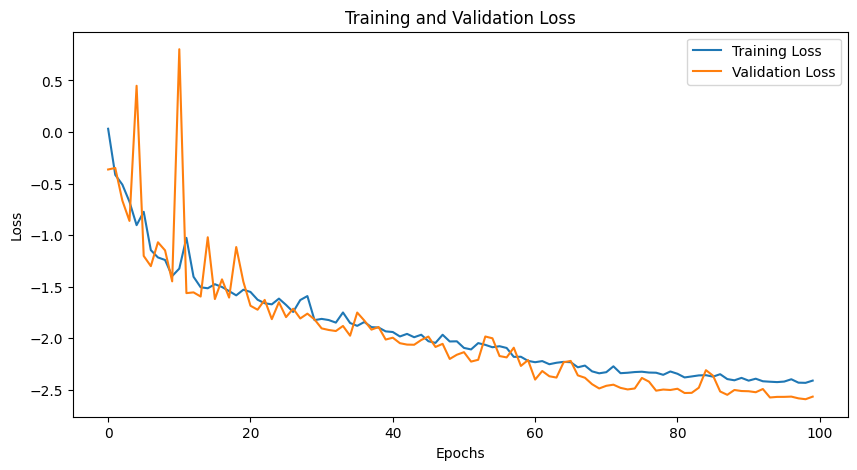

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()